# Rivet style analysis plots in MATPLOTLIB

Easier way to do rivet style final state analysis when only plots required are the final state variables/kinematics.  Requires pyhepmc (a python binding for hepmc from c++) and matplotlib.pyplot.

Data used can be found [Here](https://opendata.cern/record/160002) - Specifically the file named HEPMC.43646139._000001.tar.gz.1 under the list.

The Baler reconstructed 4momenta is found in "".decompressed.npz"" and the notebook to reconstuct these into a HEPMC file is "write_final_state_momenta.ipynb".

The config to run Baler is found under configs as baler_configs_1.py, although the epoches can be reduced to around 200 for 99.99% of accuracy. 

In [61]:
from dataclasses import dataclass, field
from typing import Tuple, List, Union, Callable, Dict, Any

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PowerTransformer
import pyhepmc 
from pyhepmc import GenEvent, FourVector, GenParticle
from pyhepmc.io import ReaderAsciiHepMC2, WriterAsciiHepMC2

First define functions for the logic of the final state particles that returns the final state particles and another for reading the input file(s) and retrieveing and store the 4-momentum of all final state particles. 

Functions used as read_get_final_states() with the arguments either a str to a file or a list of strings to files -> If used as a list of strings it concatinates the results back into one list, so if want to use for comparing two distriubtions have to call it seperately on the seperate files.

In [ ]:
def final_state_logic(event : GenEvent) -> List[GenParticle]:
    """Given an input of a GenEvent from a HEPMC introduces the logic to find the 2 final state electrons 
        from the Drell-Yan Z -> ee process. Very simple logic requiring a Z boson with 2 final state electrons
        coming from its end vertex.
    """
    e_pair = list()
    for particles in event.particles:
        # Check for Z boson
        if particles.pid == 23:
            end_vertex = particles.end_vertex
            if end_vertex.particles_out is None:
                continue
            # Loop through daughters of its end vertex
            for daughter_particles in end_vertex.particles_out:
                if abs(daughter_particles.pid) == 11 and daughter_particles.status == 1:
                    e_pair.append(daughter_particles)
    momentum_array = [e_pair[0].momentum.px,e_pair[0].momentum.py,e_pair[0].momentum.pz,e_pair[0].momentum.e
                      ,e_pair[1].momentum.px,e_pair[1].momentum.py,e_pair[1].momentum.pz,e_pair[1].momentum.e]
    return momentum_array

def read_hepmc_file_get_final_states(input_file: str) -> List[List[GenParticle]]:
    """Function to read a single hepmc file, read all the events and extact
        the final state electron pairs from each event.
        Args:    
            input_file (str) : name/location of input file
        Returns:
            List[List[GenParicle]]: Each list entry is a list of GenParitcles 
                from a singular event.
    """
    # Create pyhepmc GenEvent to be able to read in the Event Gen
    event = GenEvent()
    electron_pairs = []
    with ReaderAsciiHepMC2(input_file) as reader:
        # Continues untill all events are read, if a standarad open data single 
        # file this would be 10,000 events
        while not reader.failed():
            if reader.failed():
                break
            reader.read_event(event)

            candidate_pair = final_state_logic(event)
            # Stop empty events appending
            if candidate_pair:
                electron_pairs.append(candidate_pair)
    return electron_pairs

def read_get_final_states(input_files: Union[str, List[str]]) -> List[Tuple[GenParticle]]:
    """Function that either reads in a Lit of strings or a string of a file name 
        that corresponds to a HEPMC - no name checking logic involved as 
        reader in read_hepmc_file will fail if it is not anyway
        Args:
            input_files : either a str or a list of strings
        Returns:
            List[List[GenParicle]]: Each list entry is a list of GenParitcles 
            from a singular event.
    """
    ## This ensures the logic is the same for either string or list input
    files = input_files if isinstance(input_files, list) else [input_files]

    four_momenta = []
    
    for file in files:
        four_momenta += read_hepmc_file_get_final_states(file)
    return four_momenta

def read_momenta_from_npz(file_to_read):
    """Function to recieve the momenta vectors from a Baler style npz"""
    file_object = np.load(file_to_read)
    return file_object["data"]

Now that we have the functions to read the files and get the final state particles we know need functions to easily make plots.

First we will get the particle sof both the original and reconstructed particles.

In [ ]:
#original_particles = read_get_final_states( "../DATA/HEPMC.43646139._000001.hepmc")
#reconstructed_particles = read_get_final_states("../processedData/reinputed_final_state.hepmc")

original_particles = read_momenta_from_npz("../DATA/100-000Events.npz")
reconstructed_particles = read_momenta_from_npz("../processedData/Scaledreconstructed3.npz")

Next we will define classes for PlotConfigurables and a function to plot both the distribution histogram and the ratio histrogram.

The make_invariant_mass_plots is first hard encoded to produce a plot for the invariant mass of the system, and can be called with the lists produced from read_get_final_states(), with either a len 2 list or as just the result from the read_get_final_states, if the former you get two overlapped distrubtions and a ratio plot, if the latter you get just the distribution of that set.

In [ ]:
@dataclass
class PlotConfiguration:
    """Standard configurables for a plot in matplotlib
    """
    # Titles and axis labels
    xlabel: str
    ylabel: str
    title: str
    range: tuple[int, int]

    legend: bool = True
  
    label: str = "Plot"
    # Figure configurables
    figsize: tuple[int, int] = (8, 6)

    # Axis configurables
    x_scale: str = "linear"
    y_scale: str = "log"


@dataclass
class HistConfigurations(PlotConfiguration):
    """Configurable specific to the histogram plot used here.
    """

    bins: int = 100
    use_range_over_bin_y_label: bool = True
    
    # Second label
    label_two: str = "Plot 2"
    
    # Hist plotting types
    hist_type: str = "step"

    ## Configs for the ratio plot on the bottom
    height_ratios: tuple[int, int] = (9, 2)
    ratio_y_label: str = "ratio"
    ratio_y_rotation: int = 0
    ratio_y_size: int = 15
    ratio_y_pad: int = 20


@dataclass
class CutConfigurations:
    """Dataclass to store configurables of Cuts, key is a callable cut function defined as a 
    EventCuts polymorphism and the value is a dictionary of the parameters for the specific 
    cut (upper bound, lower_bound"""
    cuts: Dict[Callable, Dict[str, Any]] = field(default_factory = dict)

    def add_cut(self, cut_func: Callable, **params):
        self.cuts[cut_func] = params
    

class EventCuts:
    def __init__(self, **kwargs):
        self.cut_function = self.make_cuts
        self.cut_indexes = None
        self.cut_config = kwargs["cut_config"] 
        
    def fit_cuts(self, events):
        mask = np.zeros(len(events), dtype=bool)
        for cut_func, params in self.cut_config.cuts.items():
            cutter = cut_func(**params)  
            mask |= cutter.make_cuts(events) 
        self.cut_indexes = mask
    
    def make_cuts(self, events):
        return events[:, ~self.cut_indexes]
    

class TransverseMomentumCut(EventCuts):
    def __init__(self, **cut_paramaters):
        self.cut_indexes = None
        self.pt0_lower_bound = cut_paramaters.get("pt0_lower", 0)
        self.pt0_upper_bound = cut_paramaters.get("pt0_upper", np.inf)
        self.pt1_lower_bound = cut_paramaters.get("pt1_lower", 0)
        self.pt1_upper_bound = cut_paramaters.get("pt1_upper", np.inf)
    def make_cuts(self, events):
        cut_func = np.vectorize(self._momentum_cuts, signature='(n)->()')
        self.cut_indexes = cut_func(events).astype(bool)
        return self.cut_indexes
    
    def _momentum_cuts(self, event):
        pt0, pt1 = self._calculate_transverse_momentum(event)
        if pt0 < self.pt0_lower_bound or pt0 > self.pt0_upper_bound:
            return 1
        if pt1 < self.pt1_lower_bound or pt1 > self.pt1_upper_bound:
            return 1
        return 0

    def _calculate_transverse_momentum(self, event):
        pt0 = np.sqrt(np.sum(event[0:2] **2 ))
        pt1 = np.sqrt(np.sum(event[4:6] **2 ))
        return pt0, pt1


class EtaCut(EventCuts):
    def __init__(self, **cut_paramaters):
        self.cut_indexes = None
        self.eta_min = cut_paramaters.get("eta_min", 1.37)
        self.eta_max = cut_paramaters.get("eta_max", 1.52)
    def make_cuts(self, events):
        cut_func = np.vectorize(self._cut_eta, signature="(n)->()")
        self.cut_indexes = cut_func(events).astype(bool)
        return self.cut_indexes
    def _cut_eta(self, event):
        eta0, eta1 = self._calculate_eta(event)

        if abs(eta0) > self.eta_min and abs(eta0) < self.eta_max:
            return 1
        if abs(eta1) > self.eta_min and abs(eta1) < self.eta_max:
            return 1
        return 0
       

    def _calculate_eta(self, event):
        px0, py0, pz0 = event[0], event[1], event[2]
        p0 = np.sqrt(px0**2 + py0**2 + pz0**2)
        eta0 = 0.5 * np.log((p0 + pz0) / (p0 - pz0)) if p0 != abs(pz0) else np.sign(pz0) * np.inf

        # Extract momentum components (px, py, pz) for particle 2
        px1, py1, pz1 = event[4], event[5], event[6]
        p1 = np.sqrt(px1**2 + py1**2 + pz1**2)
        eta1 = 0.5 * np.log((p1 + pz1) / (p1 - pz1)) if p1 != abs(pz1) else np.sign(pz1) * np.inf
        return eta0, eta1
    

def calc_invariant_mass(particle_lists: List[List[float]]) -> List[List[float]]:
    """Calculates the invariant mass and returns as lists with each entry a distribution"""
    invariant_masses = []
    for lists in particle_lists:
        l = []
        for pair in lists:
            if len(pair) != 8:
                continue
            # Extract (px, py, pz, E) for both particles
            p1 = np.array([pair[0], pair[1], pair[2], pair[3]])
            p2 = np.array([pair[4], pair[5], pair[6], pair[7]])
            combined = p1 + p2
            inv_mass = np.sqrt(combined[3]**2 - np.sum(combined[0:3]**2))
            l.append(inv_mass)
        invariant_masses.append(l)
    invariant_masses = np.array(invariant_masses, dtype=float)
    return invariant_masses

def calc_transverse_momentum(particle_lists: List[List[float]]) -> List[List[float]]:
    """Calculates transverse momentum and returns as lists with each entry a distribution"""
    transverse_momentums  = []
    for lists in particle_lists:
        l = []
        for pair in lists:
            if len(pair) != 8:
                continue
            pt1 = np.sqrt(np.square(pair[0]) + np.square(pair[1]))
            pt2 = np.sqrt(np.square(pair[4]) + np.square(pair[5]))
            l.append(pt1)
            l.append(pt2)
        transverse_momentums.append(l)
    transverse_momentums = np.array(transverse_momentums, dtype = float)
    print(transverse_momentums.shape)
    return transverse_momentums

def calc_energy(particle_lists: List[List[float]]) -> List[List[float]]:
    """Calculates energies and returns as lists with each entry a distribution"""
    energies = []
    for lists in particle_lists:
        l = []
        for pair in lists:
            if len(pair) != 8:
                continue
            energy1 = pair[3]  # Energy component of particle 1
            energy2 = pair[7]  # Energy component of particle 2
            l.append(energy1)
            l.append(energy2)
        energies.append(l)
    energies = np.array(energies, dtype=float)
    print(energies.shape)
    return energies

def calc_px(particle_lists: List[List[float]]) -> List[List[float]]:
    
    """Calculates(retrieves) momentum in x direction and returns as lists with each entry a distribution"""
    pxs = []
    for lists in particle_lists:
        l = []
        for pair in lists:
            if len(pair) != 8:
                continue
            l.append(pair[0])
            l.append(pair[4])
        pxs.append(l)
    pxs = np.array(pxs, dtype=float)
    return pxs

def get_e_0(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the e[0] for each particle in each list."""
    return np.array(
        [[particle[3] for particle in particles if len(particle) == 8] 
         for particles in particle_lists],
        dtype=float
    )

def get_px_0(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the px[0] for each particle in each list."""
    return np.array(
        [[particle[0] for particle in particles if len(particle) == 8] 
            for particles in particle_lists],
        dtype=float
    )

def get_py_0(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the py[0]  for each particle in each list."""
    return np.array(
        [[particle[1] for particle in particles if len(particle) == 8] 
            for particles in particle_lists],
        dtype=float
    )

def get_pz_0(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the pz[0] for each particle in each list."""
    return np.array(
        [[particle[2] for particle in particles if len(particle) == 8] 
            for particles in particle_lists],
        dtype=float
    )

def get_e_1(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the e[1] for each particle in each list."""
    return np.array(
        [[particle[7] for particle in particles if len(particle) == 8] 
         for particles in particle_lists],
        dtype=float
    )

def get_px_1(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the px[0] for each particle in each list."""
    return np.array(
        [[particle[4] for particle in particles if len(particle) == 8] 
            for particles in particle_lists],
        dtype=float
    )

def get_py_1(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the py[1] for each particle in each list."""
    return np.array(
        [[particle[5] for particle in particles if len(particle) == 8] 
            for particles in particle_lists],
        dtype=float
    )

def get_pz_1(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts the pz[1] for each particle in each list."""
    return np.array(
        [[particle[6] for particle in particles if len(particle) == 8] 
            for particles in particle_lists],
        dtype=float
    )
from sklearn.preprocessing import StandardScaler, QuantileTransformer
def get_test(particle_lists: List[List[float]]) -> np.ndarray:
    """Extracts pz[0] for each particle and applies a power transform fitted to index[1] of the first row."""
    
    # Extract pz[0] values
    pz_array = np.array(
        [[particle[2] for particle in particles if len(particle) == 8]
         for particles in particle_lists],
        dtype=float
    )

    if pz_array.size == 0 or pz_array.shape[1] < 2:
        raise ValueError("Not enough data to fit PowerTransformer at index[1] in the first row.")
    
    print(pz_array.shape)
    # Select value at [0, 1] for fitting
    fit_value = pz_array[1, :]
    print(fit_value.shape)
    
    # Fit PowerTransformer on the single value and apply to full array
    pt = QuantileTransformer()
    pt.fit(fit_value.reshape(-1 , 1))  
    
    pz0_fitted = pt.transform(pz_array[0 , : ].reshape(-1, 1))
    pz1_fitted = pt.transform(pz_array[1 , : ].reshape(-1, 1))
    print(np.concatenate((pz0_fitted, pz1_fitted), axis =1).T.shape)
    return np.concatenate((pz0_fitted, pz1_fitted), axis =1).T


In [ ]:

## To do make one of the arguments a function that returns the desired quantity for plotting.
def make_distribution_plots(particle_lists: List[List[float]], 
                                variable_function, 
                                config: HistConfigurations,
                                cut_config: CutConfigurations = None) -> None:
    """ Function to create histogram plots using distributions, either takes 1 or 2 
    particle lists as input, if 1 produces a singular plot of a histogram, if 2 makes overlapping
    histogram plots on top panel and ratio plot on the smaller bottom panel.

    Calculates invariant mass of each lepton pair and stores in an array.

    If one input so particle_list[0][0] is a GenParticle turn into a list of lists of lists for 
    homogenity.

    """

    # Check number of distributions
    if particle_lists is None:
        raise AttributeError("Particle list is empty")
    if isinstance(particle_lists[0][0], float):
        raw_particle_lists = [particle_lists]
        num_dist = 1
    else:
        if len(particle_lists) > 2:
            raise AttributeError("Maximum 2 distibutions allowed")
        raw_particle_lists = particle_lists
        num_dist = 2
    raw_particle_lists = np.array(raw_particle_lists)
    if cut_config:
        event_cutter = EventCuts(**{"cut_config" : cut_config})
        event_cutter.fit_cuts(raw_particle_lists[1])
        raw_particle_lists = event_cutter.make_cuts(raw_particle_lists)
    
    # Catch if an try except block as can't do get_attr on the notebook.
    try:
        variable_distributions = variable_function(raw_particle_lists)
    except:
        raise NameError(f"{variable_function} : function does not exist")

    # Create figure and add title
    fig = plt.figure(figsize = config.figsize)
    plt.suptitle(config.title)

    # If compare of singular
    if num_dist == 1:
        pass
    else:
        gs = fig.add_gridspec(2, 1, height_ratios=config.height_ratios, hspace=0)
        
        ax_top = fig.add_subplot(gs[0])
        ax_bot = fig.add_subplot(gs[1], sharex=ax_top)

        # Removes ticks from the top plot
        ax_top.tick_params(axis='x',
                   labelbottom=False, 
                   labeltop=False) 


        # Save bin counts of each and bin_edges once for ratio plot
        (first_bins, bin_edges, _) = ax_top.hist(variable_distributions[0],
                    bins = config.bins,
                    range = config.range,
                    histtype=config.hist_type,
                    label = config.label)
        (second_bins, _ , _) = ax_top.hist(variable_distributions[1], 
                    bins = config.bins,
                    range = config.range,
                    histtype=config.hist_type,
                    label = config.label_two)
        
        # Calculate ratios and the values of x to plot at 
        bin_ratios = [f_b / s_b for (f_b, s_b) in zip(first_bins, second_bins)]
        plotting_x = [(bin_edges[i+1] + bin_edges[i])/2  for i in range(0, len(bin_edges) - 1)]
        
        ax_bot.scatter(x = plotting_x, y = bin_ratios, marker = "x")

        # Plot configurables
        if config.legend:
            ax_top.legend()


        ax_bot.set_xlabel(config.xlabel)
        if config.use_range_over_bin_y_label:
            range_over_bin = f"per {abs((config.range[1] -  config.range[0])/config.bins)} MeV"
        else:
            range_over_bin = ""
            
        ax_top.set_ylabel(config.ylabel + range_over_bin)
        ax_bot.set_xscale(config.x_scale)
        ax_top.set_yscale(config.y_scale)
        ax_bot.set_ylabel(
                            config.ratio_y_label,
                            rotation = config.ratio_y_rotation,
                            size = config.ratio_y_size,
                            labelpad= config.ratio_y_pad
                        )
     
        ax_bot.set_xlim(config.range) 
        

Now producing a simple plot of the reconstructed vs original dilepton invariant masses. 

In [ ]:
cut_config = CutConfigurations()
cut_config.add_cut(TransverseMomentumCut, pt0_lower=25000,  pt1_lower=20000)
cut_config.add_cut(EtaCut)

In [ ]:
invariant_mass_config = HistConfigurations(r"Invariant Mass $m_{ll}$",  r"Events ", "",
                                           legend = True, range = (0, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = r"$\frac{m_{recon}}{m_{orig}}$")

make_distribution_plots([reconstructed_particles, original_particles], calc_invariant_mass, invariant_mass_config, cut_config=cut_config)

In [ ]:
transvere_momentum_config = HistConfigurations(r"Transverse Momentum $p_t$",  r"Events ", "",
                                           legend = True, range = (0, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           
                                           ratio_y_label = r"$\frac{pt_{recon}}{pt_{orig}}$")

make_distribution_plots([reconstructed_particles, original_particles], calc_transverse_momentum, transvere_momentum_config, cut_config=cut_config)

In [ ]:
energy_config = HistConfigurations(r"Energies $e$",  r"Events ", "",
                                           legend = True, range = (0, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = r"$\frac{e_{recon}}{e_{orig}}$")

make_distribution_plots([reconstructed_particles, original_particles], calc_energy, energy_config, cut_config=cut_config)

In [ ]:
energy_config = HistConfigurations(r"px",  r"Events ", "",
                                           legend = True, range = (-400000, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = r"$\frac{px_{recon}}{px_{orig}}$")

make_distribution_plots([reconstructed_particles, original_particles], calc_px, energy_config, cut_config=cut_config)

(2, 86355)
(86355,)
(2, 86355)


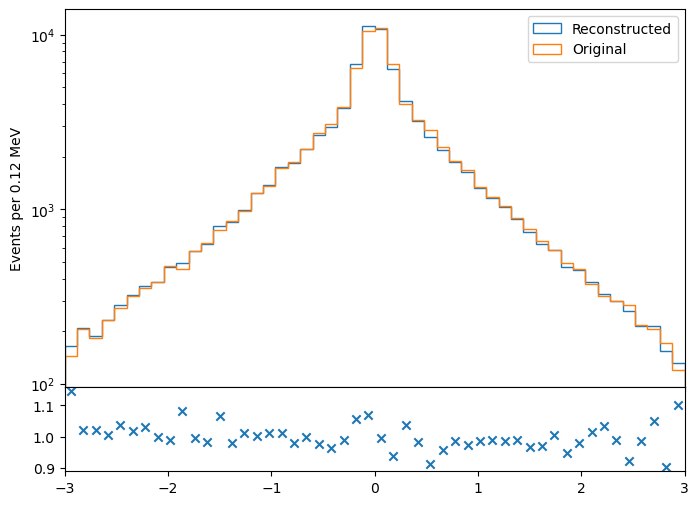

In [78]:
energy_config = HistConfigurations(r"",  r"Events ", "",
                                           legend = True, range = (-3
                                                                   , 3),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = "")

make_distribution_plots([reconstructed_particles, original_particles], get_test, energy_config, cut_config = cut_config)